By Yash Jain (yashj133.yj@gmail.com)

Task1: https://colab.research.google.com/drive/1vkqoj-lzdnP8Yyt9MLn6Lgs2ZTXjxj-A?usp=sharing

### Table of content:
>1. [Importing Libraries and load data](#1)
>2. [Preprocess data (Remove unwanted cols, adjust skewness, perform standard scaler, one hot encoding and split data into train and test)](#2)
>3. [Try fitting data into various models to findout best performing one](#3)
>4. [Tune best performing model to get better result](#4)
>5. [Prepare deployment script](#5) 

<a name="1"></a>
Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model

from sklearn.model_selection import GridSearchCV

# Algorithmns models to be compared
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

from joblib import dump, load

Loading csv files into dataframe and merging them

In [ ]:
df_loan = pd.read_csv('/content/loan.csv')
df_app = pd.read_csv('/content/applicant.csv')
df_merged = pd.merge(df_loan, df_app, on="applicant_id")

In [ ]:
df_merged.head()

,loan_application_id,applicant_id,Months_loan_taken_for,Purpose,Principal_loan_amount,EMI_rate_in_percentage_of_disposable_income,Property,Has_coapplicant,Has_guarantor,Other_EMI_plans,...,Housing,Years_at_current_residence,Employment_status,Has_been_employed_for_at_least,Has_been_employed_for_at_most,Telephone,Foreign_worker,Savings_account_balance,Balance_in_existing_bank_account_(lower_limit_of_bucket),Balance_in_existing_bank_account_(upper_limit_of_bucket)
0,d68d975e-edad-11ea-8761-1d6f9c1ff461,1469590,6,electronic equipment,1169000,4,real estate,0,0,NaN,...,own,4,skilled employee / official,7 years,NaN,Registered under the applicant's name,1,NaN,NaN,0
1,d68d989e-edad-11ea-b1d5-2bcf65006448,1203873,48,electronic equipment,5951000,2,real estate,0,0,NaN,...,own,2,skilled employee / official,1 year,4 years,NaN,1,Low,0,2 lac
2,d68d995c-edad-11ea-814a-1b6716782575,1432761,12,education,2096000,2,real estate,0,0,NaN,...,own,3,unskilled - resident,4 years,7 years,NaN,1,Low,NaN,NaN
3,d68d99fc-edad-11ea-8841-17e8848060ae,1207582,42,FF&E,7882000,2,building society savings agreement/life insurance,0,1,NaN,...,for free,4,skilled employee / official,4 years,7 years,NaN,1,Low,NaN,0
4,d68d9a92-edad-11ea-9f3d-1f8682db006a,1674436,24,new vehicle,4870000,3,NaN,0,0,NaN,...,for free,4,skilled employee / official,1 year,4 years,NaN,1,Low,NaN,0


In [ ]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 27 columns):
 #   Column                                                    Non-Null Count  Dtype 
---  ------                                                    --------------  ----- 
 0   loan_application_id                                       1000 non-null   object
 1   applicant_id                                              1000 non-null   int64 
 2   Months_loan_taken_for                                     1000 non-null   int64 
 3   Purpose                                                   988 non-null    object
 4   Principal_loan_amount                                     1000 non-null   int64 
 5   EMI_rate_in_percentage_of_disposable_income               1000 non-null   int64 
 6   Property                                                  846 non-null    object
 7   Has_coapplicant                                           1000 non-null   int64 
 8   Has_guarantor                

<a name="2"></a>
Removing unwanted columns

In [ ]:
df_merged.drop(columns=["loan_application_id","applicant_id","Other_EMI_plans", "Telephone", "Balance_in_existing_bank_account_(lower_limit_of_bucket)", "Balance_in_existing_bank_account_(upper_limit_of_bucket)"], axis=1, inplace=True)

fillna for categorical columns with mode value

In [ ]:
cat_cols=list(df_merged.select_dtypes(include = 'object').columns)
for cat_col in cat_cols:
  df_merged[cat_col].fillna(df_merged[cat_col].value_counts().index[0], inplace=True)

fillna for continous columns with mean value

In [ ]:
num_cols=[i for i in df_merged.columns if i not in cat_cols]
for num_col in num_cols:
  df_merged[num_col].fillna(df_merged[num_col].mean(), inplace=True)

In [ ]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   Months_loan_taken_for                        1000 non-null   int64 
 1   Purpose                                      1000 non-null   object
 2   Principal_loan_amount                        1000 non-null   int64 
 3   EMI_rate_in_percentage_of_disposable_income  1000 non-null   int64 
 4   Property                                     1000 non-null   object
 5   Has_coapplicant                              1000 non-null   int64 
 6   Has_guarantor                                1000 non-null   int64 
 7   Number_of_existing_loans_at_this_bank        1000 non-null   int64 
 8   Loan_history                                 1000 non-null   object
 9   high_risk_applicant                          1000 non-null   int64 
 10  Primary_appli

Selecting continous columns

In [ ]:
selected_cols = ["Months_loan_taken_for","Principal_loan_amount", "Primary_applicant_age_in_years"]
num_col_data = df_merged.loc[:,selected_cols]

Plotting distplot to check skewness

In [ ]:
def distributions(df):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.distplot(df["Months_loan_taken_for"], ax=ax1)
    sns.distplot(df["Principal_loan_amount"], ax=ax2)
    sns.distplot(df["Primary_applicant_age_in_years"], ax=ax3)
    plt.tight_layout()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

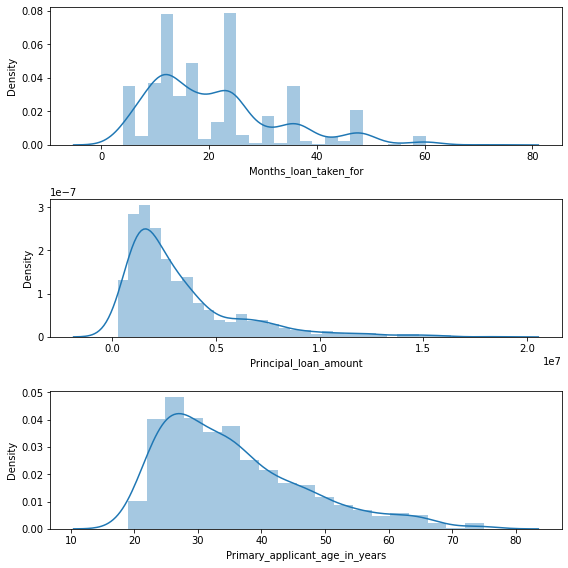

In [ ]:
distributions(num_col_data)

We see records are skewed, so apply log onto it to remove skewness

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

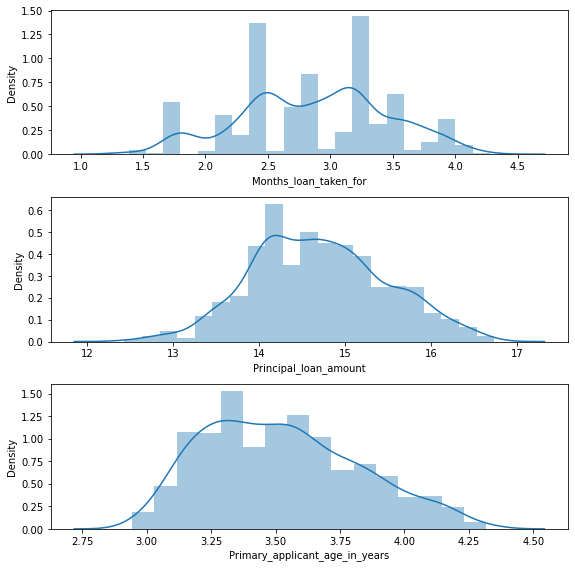

In [ ]:
log_num_data = np.log(num_col_data)
distributions(log_num_data)

Apply standard scaler onto skewed records

In [ ]:
scaler = StandardScaler()
scaled_num_data = pd.DataFrame(scaler.fit_transform(log_num_data), columns=selected_cols)

In [ ]:
scaled_num_data

,Months_loan_taken_for,Principal_loan_amount,Primary_applicant_age_in_years
0,-1.864869,-0.933901,2.271006
1,1.708369,1.163046,-1.446152
2,-0.673790,-0.181559,1.226696
3,1.478913,1.525148,0.942455
4,0.517289,0.904743,1.488620
...,...,...,...
995,-0.673790,-0.424376,-0.301466
996,0.900731,0.604255,0.549317
997,-0.673790,-1.416199,0.378110
998,1.597468,-0.345911,-1.297780


Remove repeated columns and merge concat above two dataframes.

In [ ]:
df_merged.drop(columns=selected_cols, inplace=True, axis=1)

In [ ]:
df=pd.concat([df_merged,scaled_num_data], axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Purpose                                      1000 non-null   object 
 1   EMI_rate_in_percentage_of_disposable_income  1000 non-null   int64  
 2   Property                                     1000 non-null   object 
 3   Has_coapplicant                              1000 non-null   int64  
 4   Has_guarantor                                1000 non-null   int64  
 5   Number_of_existing_loans_at_this_bank        1000 non-null   int64  
 6   Loan_history                                 1000 non-null   object 
 7   high_risk_applicant                          1000 non-null   int64  
 8   Gender                                       1000 non-null   object 
 9   Marital_status                               1000 non-null   object 
 10  N

Create list of encoded columns name which will be used in one hot encoding

In [ ]:
cat_cols_encoded = []
for col in cat_cols:
  cat_cols_encoded += [f"{col[0]}_{cat}" for cat in list(df[col].unique())]
cat_cols_encoded

['P_electronic equipment',
 'P_education',
 'P_FF&E',
 'P_new vehicle',
 'P_used vehicle',
 'P_business',
 'P_domestic appliances',
 'P_repair costs',
 'P_career development',
 'P_real estate',
 'P_building society savings agreement/life insurance',
 'P_car or other',
 'L_critical/pending loans at other banks',
 'L_existing loans paid back duly till now',
 'L_delay in paying off loans in the past',
 'L_no loans taken/all loans paid back duly',
 'L_all loans at this bank paid back duly',
 'G_male',
 'G_female',
 'M_single',
 'M_divorced/separated/married',
 'M_divorced/separated',
 'M_married/widowed',
 'H_own',
 'H_for free',
 'H_rent',
 'E_skilled employee / official',
 'E_unskilled - resident',
 'E_management / self-employed / highly qualified employee / officer',
 'E_unemployed / unskilled - non-resident',
 'H_7 years',
 'H_1 year',
 'H_4 years',
 'H_0 year',
 'H_4 years',
 'H_7 years',
 'H_0 year',
 'H_1 year',
 'S_Low',
 'S_High',
 'S_Very high',
 'S_Medium']

Perform one hot encoding on categorical columns

In [ ]:
oh_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_cols = oh_encoder.fit_transform(df[cat_cols])
df_enc = pd.DataFrame(encoded_cols, columns=cat_cols_encoded)

Remove repeated column

In [ ]:
df.drop(columns=cat_cols, inplace=True, axis=1)

In [ ]:
df_final=pd.concat([df,df_enc], axis=1)
df_final

,EMI_rate_in_percentage_of_disposable_income,Has_coapplicant,Has_guarantor,Number_of_existing_loans_at_this_bank,high_risk_applicant,Number_of_dependents,Years_at_current_residence,Foreign_worker,Months_loan_taken_for,Principal_loan_amount,...,H_4 years,H_0 year,H_4 years,H_7 years,H_0 year,H_1 year,S_Low,S_High,S_Very high,S_Medium
0,4,0,0,2,0,1,4,1,-1.864869,-0.933901,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,2,0,0,1,1,1,2,1,1.708369,1.163046,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,2,0,0,1,0,2,3,1,-0.673790,-0.181559,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,2,0,1,1,0,2,4,1,1.478913,1.525148,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,3,0,0,2,1,2,4,1,0.517289,0.904743,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,0,0,1,0,1,4,1,-0.673790,-0.424376,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
996,4,0,0,1,0,1,4,1,0.900731,0.604255,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
997,4,0,0,1,0,1,4,1,-0.673790,-1.416199,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
998,4,0,0,1,1,1,4,1,1.597468,-0.345911,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


Perform train test split

In [ ]:
X = df_final.drop('high_risk_applicant', 1).values
y = df_final["high_risk_applicant"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

<ipython-input-24-b25aee1a98c8>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df_final.drop('high_risk_applicant', 1).values


In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((750, 52), (250, 52), (750,), (250,))

<a name="3"></a>
Training multiple models to check which one performs best.

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

LR: 0.326385 (0.094289)
LDA: 0.365899 (0.092384)
KNN: 0.287021 (0.067615)
CART: 0.447521 (0.095784)
NB: 0.628818 (0.134508)
RF: 0.273933 (0.079039)
SVM: 0.005000 (0.015000)
XGB: 0.298347 (0.078281)


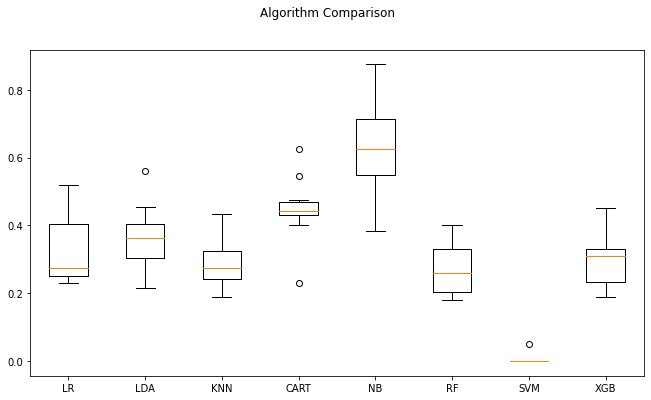

In [ ]:
# to feed the random state
seed = 7

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('XGB', XGBClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'recall'

for name, model in models:
        kfold = KFold(n_splits=10, random_state=seed,shuffle=True)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
# boxplot algorithm comparison
fig = plt.figure(figsize=(11,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

As we can clearly see that Gaussian Naive Bayes (GaussianNB) performs the best with recall score of 0.62.
So we will try to tune it for better results.

Train model on complete dataset

In [ ]:
GNB = GaussianNB()
model = GNB.fit(X_train, y_train)

In [ ]:
print("Training score data: ")
print(model.score(X_train, y_train))

Training score data: 
0.6933333333333334


Testing trained model

In [ ]:
y_pred = model.predict(X_test)

print(accuracy_score(y_test,y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

0.632


[[117  61]
 [ 31  41]]


              precision    recall  f1-score   support

           0       0.79      0.66      0.72       178
           1       0.40      0.57      0.47        72

    accuracy                           0.63       250
   macro avg       0.60      0.61      0.59       250
weighted avg       0.68      0.63      0.65       250



<a name="4"></a>
Tuning model to get better results.

In [ ]:
features = []
features.append(('pca', PCA(n_components=2))) #PCA to reduce dimensions
features.append(('select_best', SelectKBest(k=6))) #select 6 Best scores, scored using default f_classif scoring function.
feature_union = FeatureUnion(features)
# create pipeline
estimators = []
estimators.append(('feature_union', feature_union)) #perform feature selection
estimators.append(('logistic', GaussianNB())) #fit to model
model = Pipeline(estimators)
# evaluate pipeline
seed = 7
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
results = cross_val_score(model, X_train, y_train, cv=kfold)
print(results.mean())

0.6973333333333334


In [ ]:
model.fit(X_train, y_train)
print("Train score data: ")
print(model.score(X_train, y_train))

y_pred = model.predict(X_test)
print("Test score data: ")
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))

Train score data: 
0.7146666666666667
Test score data: 
0.68
[[156  22]
 [ 58  14]]


We managed to get accuracy of 71% on training and 68% on testing. This can be improved further but for now we will moving forward with this model onto deployment stage.

Saving required files

In [ ]:
df_final.to_csv('clean_final.csv')
dump(scaler,'std_scaler.joblib')
dump(oh_encoder, 'oh_encoder.joblib')
dump(model, 'model_file.joblib')

['model_file.joblib']

<a name="5"></a>
### Deployment Test

preprocess to get deployment like input i.e. in JSON format

In [ ]:
df_loan = pd.read_csv('/content/loan.csv')
df_app = pd.read_csv('/content/applicant.csv')
temp_df = pd.merge(df_loan, df_app, on="applicant_id")
temp_df = dict(temp_df.loc[2,:])

In [ ]:
temp_df

{'loan_application_id': 'd68d995c-edad-11ea-814a-1b6716782575',
 'applicant_id': 1432761,
 'Months_loan_taken_for': 12,
 'Purpose': 'education',
 'Principal_loan_amount': 2096000,
 'EMI_rate_in_percentage_of_disposable_income': 2,
 'Property': 'real estate',
 'Has_coapplicant': 0,
 'Has_guarantor': 0,
 'Other_EMI_plans': nan,
 'Number_of_existing_loans_at_this_bank': 1,
 'Loan_history': 'critical/pending loans at other banks',
 'high_risk_applicant': 0,
 'Primary_applicant_age_in_years': 49,
 'Gender': 'male',
 'Marital_status': 'single',
 'Number_of_dependents': 2,
 'Housing': 'own',
 'Years_at_current_residence': 3,
 'Employment_status': 'unskilled - resident',
 'Has_been_employed_for_at_least': '4 years',
 'Has_been_employed_for_at_most': '7 years',
 'Telephone': nan,
 'Foreign_worker': 1,
 'Savings_account_balance': 'Low',
 'Balance_in_existing_bank_account_(lower_limit_of_bucket)': nan,
 'Balance_in_existing_bank_account_(upper_limit_of_bucket)': nan}

In [ ]:
del_columns=["loan_application_id","applicant_id","Other_EMI_plans", "Telephone", "Balance_in_existing_bank_account_(lower_limit_of_bucket)", "Balance_in_existing_bank_account_(upper_limit_of_bucket)"]
for d_c in del_columns:
  del temp_df[d_c]

In [ ]:
y_true=temp_df['high_risk_applicant']
del temp_df['high_risk_applicant']

In [ ]:
temp_df

{'Months_loan_taken_for': 12,
 'Purpose': 'education',
 'Principal_loan_amount': 2096000,
 'EMI_rate_in_percentage_of_disposable_income': 2,
 'Property': 'real estate',
 'Has_coapplicant': 0,
 'Has_guarantor': 0,
 'Number_of_existing_loans_at_this_bank': 1,
 'Loan_history': 'critical/pending loans at other banks',
 'Primary_applicant_age_in_years': 49,
 'Gender': 'male',
 'Marital_status': 'single',
 'Number_of_dependents': 2,
 'Housing': 'own',
 'Years_at_current_residence': 3,
 'Employment_status': 'unskilled - resident',
 'Has_been_employed_for_at_least': '4 years',
 'Has_been_employed_for_at_most': '7 years',
 'Foreign_worker': 1,
 'Savings_account_balance': 'Low'}

Above is how we expect our input to be.

In [ ]:
cat_cols=['Purpose',
'Property',
 'Loan_history',
 'Gender',
 'Marital_status',
 'Housing',
 'Employment_status',
 'Has_been_employed_for_at_least',
 'Has_been_employed_for_at_most',
 'Savings_account_balance'
 ]

selected_cols=['Months_loan_taken_for',
 'Principal_loan_amount',
 'Primary_applicant_age_in_years']
 
other_cols=['EMI_rate_in_percentage_of_disposable_income',
 'Has_coapplicant',
 'Has_guarantor',
 'Number_of_existing_loans_at_this_bank',
 'Number_of_dependents',
 'Years_at_current_residence',
 'Foreign_worker']

In [ ]:
oh_encoder = load('/content/oh_encoder.joblib')
std_scaler = load('/content/std_scaler.joblib')
model = load('/content/model_file.joblib')

In [ ]:
cat_values=[temp_df[i] for i in cat_cols]
selected_val=[temp_df[i] for i in selected_cols]
X=[temp_df[i] for i in other_cols]

In [ ]:
oh_encoded=oh_encoder.transform([cat_values])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


In [ ]:
selected_val=np.log(selected_val)
scaled=std_scaler.transform([selected_val])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
X.extend(scaled[0])
X.extend(oh_encoded[0])

In [ ]:
X=np.array(X)
X=X.reshape(1,-1)
y_pred=model.predict(X)
print("Predicted vaues is:")
print(y_pred[0])
print("True Value is:")
print(y_true)


Predicted vaues is:
0
True Value is:
0


We see our deployment script is working fine, so now we can easily deploy it using any framework. For now I am going forward with FastAPI for deployment files for which are attached.